______  ___     ______                        _________
___   |/  /________  /_______ _______ ______________  /
__  /|_/ /_  __ \_  __ \  __ `/_  __ `__ \  _ \  __  / 
_  /  / / / /_/ /  / / / /_/ /_  / / / / /  __/ /_/ /  
/_/  /_/  \____//_/ /_/\__,_/ /_/ /_/ /_/\___/\__,_/   
                                                       
_____________ _________      ___________        _________            
___    |__  /_______  /_____ ___  /__  /_______ ______  /____________
__  /| |_  __ \  __  /_  __ `/_  /__  //_/  __ `/  __  /_  _ \_  ___/
_  ___ |  /_/ / /_/ / / /_/ /_  / _  ,<  / /_/ // /_/ / /  __/  /    
/_/  |_/_.___/\__,_/  \__,_/ /_/  /_/|_| \__,_/ \__,_/  \___//_/     
                                                                     



## Import Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras.layers
import keras.backend as K
from keras.layers import Lambda, SpatialDropout1D, Convolution1D, Dense, Activation, Input, Flatten, Dropout, GlobalMaxPooling1D
from keras.models import Model

from tensorflow.keras.layers import  Bidirectional,Flatten,Dense,Dropout,LSTM, Input,TimeDistributed,GRU,Conv1D,MaxPooling1D

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error

## Data Reading and Preprocessing

In [3]:
# Reading generated power (Solar and wind) data
# Dataset link : https://data.open-power-system-data.org/time_series/2020-10-06

data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-time_series-2020-10-06\time_series_60min_singleindex.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/time_series_60min_singleindex.csv"

df = pd.read_csv(data_path,
                 usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                 parse_dates=[0], index_col=0)

In [4]:
# As we see in the last two graphs , The wind and solar power aer seasonal  

production_wind_solar = df[['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


In [5]:
# Reading weather data to be combined with power data  
# https://data.open-power-system-data.org/weather_data/2020-09-16
# Metadata link : https://data.open-power-system-data.org/weather_data/2020-09-16/README.md


data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-weather_data-2020-09-16\weather_data.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/weather_data.csv"

weather = pd.read_csv(data_path, parse_dates=[0], index_col=0)
weather.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [6]:
# resampling weather data by day to make it ready to be combined with power data  

weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [7]:
# Meging (Solar & wind) data with (weather) data

combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,-6.495,0.0,0.0,0.100,0.0,0.0,-13.029,0.0,...,0.0,0.610,0.0,0.0,-11.515,0.0,0.0,-8.337,0.0,0.0
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0


In [8]:
# Note | we have the solar and wind data from 01/01/2015 to 30/09/2020
#                   and temperature data from 01/01/1980 to 31/12/2019
#                   we should get the intersection between them to be able to create a powerful model
#                   The intersection between them is from 
#                                             01/01/2015 to 31/12/2019

combined = combined.loc[combined.index >= '2015-01-01 00:00:00+00:00', :]
combined = combined.loc[combined.index <= '2019-12-31 23:00:00+00:00', :]

combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,NaN,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [9]:
# There are some nulls found should be filled by the mean of the same column

combined["DE_wind_generation_actual" ].fillna(combined["DE_wind_generation_actual" ].mean(), inplace=True)
combined["DE_solar_generation_actual"].fillna(combined["DE_solar_generation_actual"].mean(), inplace=True)

combined.isnull().sum()

DE_wind_generation_actual          0
DE_solar_generation_actual         0
AT_temperature                     0
AT_radiation_direct_horizontal     0
AT_radiation_diffuse_horizontal    0
                                  ..
SI_radiation_direct_horizontal     0
SI_radiation_diffuse_horizontal    0
SK_temperature                     0
SK_radiation_direct_horizontal     0
SK_radiation_diffuse_horizontal    0
Length: 86, dtype: int64

In [10]:
# It is clear that the data should be scaled to make sure that the model will give an accurate result

X_scaler = MinMaxScaler().fit(combined.iloc[:,2:])
X_scaled = X_scaler.transform(combined.iloc[:,2:])

y_scaler = MinMaxScaler().fit(combined.iloc[:,:2])
y_scaled = y_scaler.transform(combined.iloc[:,:2])

In [11]:
# Splitting data into train & test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [12]:
# Reahping the data to be suitable for forcasting 

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test .reshape(X_test .shape[0], 1, X_test .shape[1])

X_val = X_val.reshape(X_val.shape[0],1,X_val.shape[1])

## Package Models

In [13]:
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))


class lstm(tf.keras.Model):
    def __init__(self,n_steps,n_features,n_outputs=1):
        super(lstm, self).__init__()
        self.n_steps=n_steps
        self.n_features=n_features
        self.n_outputs=n_outputs
        self.lstm_1 = LSTM(128, activation='relu', return_sequences=True)
        self.lstm_2 = LSTM(64, activation='relu',  return_sequences=True)
        self.lstm_3 = LSTM(64, activation='relu')
        self.dropout_1 = Dropout(0.1)
        self.dropout_2 = Dropout(0.1)
        self.dense_1 = Dense(32, activation='relu')
        self.dense_2 = Dense(self.n_outputs)
    
    def call(self, x):

        x = self.lstm_1(x)
        x = self.dropout_1(x)
        x = self.lstm_2(x)
        x = self.lstm_3(x)
        x = self.dropout_2(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        return x
    def getModel(self):
        inp = Input(shape=(self.n_steps,self.n_features))
        x = lstm(self.n_steps, self.n_features,self.n_outputs)(inp)
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model
    

class BiLSTM(tf.keras.Model):
    def __init__(self,n_steps,n_features,n_outputs=1):
        
        super(BiLSTM, self).__init__()
        self.n_steps=n_steps
        self.n_features=n_features
        self.n_outputs=n_outputs
        self.blstm1=Bidirectional(LSTM(128 , activation='relu',  return_sequences=True))
        self.blstm2=Bidirectional(LSTM(64, activation='relu'))
        self.flatten =Flatten()
        self.fc1=Dense(32, activation='relu')
        self.drp=Dropout(0.2)
        self.fc2=Dense(self.n_outputs)
        
        
    def call(self, inputs):
        x=self.blstm1(inputs)
        x=self.blstm2(x)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.drp(x)
        x=self.fc2(x)
        return x
    def getModel(self):
        inp = Input(shape=(self.n_steps,self.n_features))
        x = BiLSTM(self.n_steps, self.n_features,self.n_outputs)(inp)
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model 
    

class GRU_model(tf.keras.Model):
    def __init__(self,n_steps,n_features,n_outputs=1):
        super(GRU_model, self).__init__()
        self.n_steps=n_steps
        self.n_features=n_features
        self.n_outputs=n_outputs
        self.gru_1= GRU(300, activation='tanh',return_sequences=True)
        self.gru_2= GRU(200, activation='tanh',return_sequences=True)
        self.dropout_1 = Dropout(0.2)
        self.gru_3= GRU(100, activation='tanh',return_sequences=True)
        self.gru_4= GRU(50, activation='tanh')
        self.dropout_2 = Dropout(0.2)
        self.dense_1 = Dense(20, activation='softmax')
        self.dense_2 = Dense(self.n_outputs)

    def call(self, x):

        x = self.gru_1(x)
        x = self.gru_2(x)
        x = self.dropout_1(x)
        x = self.gru_3(x)
        x = self.gru_4(x)
        x = self.dropout_2(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return x
    
    def getModel(self):
        inp = Input(shape=(self.n_steps,self.n_features))
        x = GRU_model(self.n_steps, self.n_features,self.n_outputs)(inp)
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model 
    
class BiGRU(tf.keras.Model):
    def __init__(self,n_steps,n_features,n_outputs=1):
        super(BiGRU, self).__init__()
        self.n_steps=n_steps
        self.n_features=n_features
        self.n_outputs=n_outputs
        self.bigru_1= Bidirectional(GRU(256, activation='tanh',return_sequences=True))
        self.dropout_1 = Dropout(0.3)   
        self.bigru_2= Bidirectional(GRU(128, activation='tanh',return_sequences=True))
        self.bigru_3= Bidirectional(GRU(64, activation='tanh',return_sequences=True))
        self.dropout_2 = Dropout(0.2)   
        self.bigru_4= Bidirectional(GRU(32, activation='tanh'))
        self.flatten_1= Flatten()
        self.dropout_3 = Dropout(0.2)   
        self.dense_1 = Dense(10, activation='softmax')
        self.flatten_2= Flatten()
        self.dropout_4 = Dropout(0.1)
        self.dense_2 = Dense(self.n_outputs)

    def call(self, x):

        x = self.bigru_1(x)
        x = self.dropout_1(x)
        x = self.bigru_2(x)
        x = self.bigru_3(x)
        x = self.dropout_2(x)
        x = self.bigru_4(x)
        x=self.flatten_1(x)
        x = self.dropout_3(x)
        x = self.dense_1(x)
        x=self.flatten_2(x)
        x = self.dropout_4(x)
        x = self.dense_2(x)
        return x
    
    def getModel(self):
        inp = Input(shape=(self.n_steps,self.n_features))
        x = BiGRU(self.n_steps, self.n_features,self.n_outputs)(inp)
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model 
    
class CNN(tf.keras.Model):
    def __init__(self, n_steps, n_features, n_outputs=1):
        super(CNN, self).__init__()
        self.n_steps=n_steps
        self.n_features=n_features
        self.n_outputs=n_outputs
        self.CNN_L1=(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
        self.CNN_L2=(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        self.CNN_L3=(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu'))           
        self.CNN_maxpooling=(MaxPooling1D(pool_size=1))
        self.CNN_flatten=(Flatten())
        self.CNN_dense1=(Dense(100, activation='relu'))
        self.CNN_droupout=(Dropout(0.3))
        self.CNN_dense2=(Dense(20, activation='relu'))
        self.CNN_dense3=(Dense(self.n_outputs))

    def call(self, x):

        x = self.CNN_L1(x)
        x = self.CNN_L2(x)
        x = self.CNN_L3(x)
        x = self.CNN_maxpooling(x)
        x = self.CNN_flatten(x)
        x = self.CNN_dense1(x)
        x = self.CNN_droupout(x)
        x = self.CNN_dense2(x)
        x = self.CNN_dense3(x)
        return x
    
    def getModel(self):
        inp = Input(shape=(self.n_steps,self.n_features))
        x = CNN(self.n_steps, self.n_features,self.n_outputs)(inp)
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model 
    
class TCN_Model:
    class TCN_layer:
        def channel_normalization(self, x):
            max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
            out = x / max_values
            return out

        def residual_block(self, x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
            original_x = x
            conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                          dilation_rate=i, padding=padding,
                          name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
            if activation == 'norm_relu':
                x = Activation('relu')(conv)
                x = Lambda(self.channel_normalization)(x)
            else:
                x = Activation(activation)(conv)

            x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

            # 1x1 conv.
            x = Convolution1D(nb_filters, 1, padding='same')(x)
            res_x = keras.layers.add([original_x, x])
            return res_x, x

        def __init__(self,
                     nb_filters=64,
                     kernel_size=2,
                     nb_stacks=1,
                     dilations=None,
                     activation='norm_relu',
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.0,
                     return_sequences=True,
                     name='tcn'):
            self.name = name
            self.return_sequences = return_sequences
            self.dropout_rate = dropout_rate
            self.use_skip_connections = use_skip_connections
            self.activation = activation
            self.dilations = dilations
            self.nb_stacks = nb_stacks
            self.kernel_size = kernel_size
            self.nb_filters = nb_filters
            self.padding = padding

            if padding != 'causal' and padding != 'same':
                raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

            if not isinstance(nb_filters, int):
                print('An interface change occurred after the version 2.1.2.')
                print('Before: tcn.TCN(i, return_sequences=False, ...)')
                print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
                print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
                raise Exception()

        def __call__(self, inputs):
            if self.dilations is None:
                self.dilations = [1, 2, 4, 8, 16, 32]
            x = inputs
            x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
            skip_connections = []
            for s in range(self.nb_stacks):
                for i in self.dilations:
                    x, skip_out = self.residual_block(x, s, i, self.activation, self.nb_filters,
                                                      self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                    skip_connections.append(skip_out)
            if self.use_skip_connections:
                x = keras.layers.add(skip_connections)
            x = Activation('relu')(x)

            if not self.return_sequences:
                output_slice_index = -1
                x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
            return x

    def getModel(self,
                 n_steps,
                 n_features,
                 n_outputs = 1,
#                  X, y,
                 tcn1_units=128,
                 tcn2_units=64,
                 tcn1_kernel_size=5,
                 tcn2_kernel_size=1,
              activation="relu",
              return_sequences=True,
              dropout=0.2):

        input  = Input(shape=(n_steps,n_features))
        output = n_outputs
        
        x = SpatialDropout1D(dropout)(input)

        x = TCN_Model.TCN_layer(tcn1_units,
                                dilations=[1, 2, 4, 8, 16],
                                kernel_size=tcn1_kernel_size,
                                return_sequences=return_sequences,
                                name='tnc1')(x)

        x = TCN_Model.TCN_layer(tcn2_units,
                                dilations=[1, 2, 4],
                                kernel_size=tcn2_kernel_size,
                                return_sequences=return_sequences,
                                name='tnc2')(x)

        max_pool = GlobalMaxPooling1D()(x)
        x = Dense(tcn2_units, activation=activation)(max_pool)
        x = Dropout(dropout)(x)
        output = Dense(output)(x)
        model = Model(inputs=input, outputs=output)
        
        return model

#### Evaluation

In [14]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))


#### Data shape

In [15]:
print(f"X_train shape -> {X_train.shape}")
print(f"y_train shape -> {y_train.shape}")
print(f"X_test  shape -> {X_test.shape}")
print(f"y_test  shape -> {y_test.shape}")

X_train shape -> (35059, 1, 84)
y_train shape -> (35059, 2)
X_test  shape -> (4383, 1, 84)
y_test  shape -> (4383, 2)


## LSTM

In [16]:
lstm_model = lstm(1,84,2).getModel() # n_steps = 1 , n_features = 84 , n_outputs = 2
lstm_model.compile(optimizer="adam",loss="mse")

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = lstm_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 8s 4ms/step - loss: 0.0190 - val_loss: 0.0144
Epoch 2/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0147 - val_loss: 0.0130
Epoch 3/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0137 - val_loss: 0.0121
Epoch 4/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 5/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0127 - val_loss: 0.0116
Epoch 6/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 7/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0122 - val_loss: 0.0108
Epoch 8/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 9/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 10/50
1096/1096 [==============================] - 4s 4ms/step - loss: 0.011

In [18]:
y_pred_train = lstm_model.predict(X_train)
y_pred_test  = lstm_model.predict(X_test) 

print("-" * 50)

print_metrics(lstm_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 0s 2ms/step
--------------------------------------------------
Train MAE  value   : 0.050 
Train MSE  value   : 0.006 
Train RMSE value   : 0.079 
Train R2   value   : 0.837 
---------------------------------------------
Test  MAE  value   : 0.053 
Test  MSE  value   : 0.007 
Test  RMSE value   : 0.084 
Test  R2   value   : 0.810 


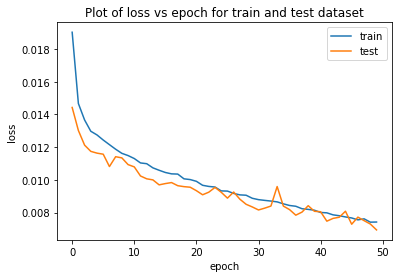

In [19]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## BiLSTM

In [20]:
bilstm_model = BiLSTM(1,84,2).getModel() # n_steps = 1 , n_features = 84 , n_outputs = 2
bilstm_model.compile(optimizer="adam",loss="mse")

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = bilstm_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 10s 5ms/step - loss: 0.0185 - val_loss: 0.0136
Epoch 2/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0147 - val_loss: 0.0130
Epoch 3/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 4/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 5/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 6/50
1096/1096 [==============================] - 5s 5ms/step - loss: 0.0125 - val_loss: 0.0110
Epoch 7/50
1096/1096 [==============================] - 5s 5ms/step - loss: 0.0122 - val_loss: 0.0113
Epoch 8/50
1096/1096 [==============================] - 5s 5ms/step - loss: 0.0119 - val_loss: 0.0106
Epoch 9/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 10/50
1096/1096 [==============================] - 5s 4ms/step - loss: 0.01

In [22]:
y_pred_train = bilstm_model.predict(X_train)
y_pred_test  = bilstm_model.predict(X_test) 

print("-" * 50)

print_metrics(bilstm_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 0s 2ms/step
--------------------------------------------------
Train MAE  value   : 0.046 
Train MSE  value   : 0.005 
Train RMSE value   : 0.073 
Train R2   value   : 0.859 
---------------------------------------------
Test  MAE  value   : 0.050 
Test  MSE  value   : 0.006 
Test  RMSE value   : 0.080 
Test  R2   value   : 0.828 


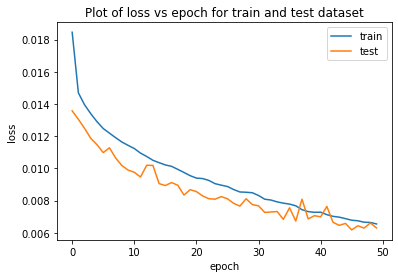

In [23]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## GRU

In [24]:
gru_model = GRU_model(1,84,2).getModel() # n_steps = 1 , n_features = 84 , n_outputs = 2
gru_model.compile(optimizer="adam",loss="mse")

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = gru_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 20s 11ms/step - loss: 0.0184 - val_loss: 0.0137
Epoch 2/50
1096/1096 [==============================] - 10s 9ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 3/50
1096/1096 [==============================] - 10s 10ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 4/50
1096/1096 [==============================] - 10s 9ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 5/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 6/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 7/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 8/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 9/50
1096/1096 [==============================] - 11s 10ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 10/50
1096/1096 [==============================] - 11s 10ms/

In [26]:
y_pred_train = gru_model.predict(X_train)
y_pred_test  = gru_model.predict(X_test) 

print("-" * 50)

print_metrics(gru_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 1s 3ms/step
--------------------------------------------------
Train MAE  value   : 0.033 
Train MSE  value   : 0.003 
Train RMSE value   : 0.053 
Train R2   value   : 0.927 
---------------------------------------------
Test  MAE  value   : 0.039 
Test  MSE  value   : 0.004 
Test  RMSE value   : 0.063 
Test  R2   value   : 0.895 


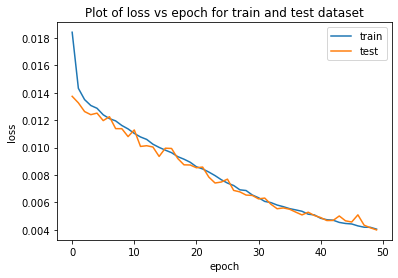

In [27]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## BiGRU

In [28]:
bigru_model = BiGRU(1,84,2).getModel() # n_steps = 1 , n_features = 84 , n_outputs = 2
bigru_model.compile(optimizer="adam",loss="mse")

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = bigru_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 31s 15ms/step - loss: 0.0201 - val_loss: 0.0141
Epoch 2/50
1096/1096 [==============================] - 13s 11ms/step - loss: 0.0163 - val_loss: 0.0133
Epoch 3/50
1096/1096 [==============================] - 13s 12ms/step - loss: 0.0155 - val_loss: 0.0135
Epoch 4/50
1096/1096 [==============================] - 13s 12ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 5/50
1096/1096 [==============================] - 14s 12ms/step - loss: 0.0144 - val_loss: 0.0122
Epoch 6/50
1096/1096 [==============================] - 13s 12ms/step - loss: 0.0140 - val_loss: 0.0121
Epoch 7/50
1096/1096 [==============================] - 13s 12ms/step - loss: 0.0139 - val_loss: 0.0123
Epoch 8/50
1096/1096 [==============================] - 14s 12ms/step - loss: 0.0138 - val_loss: 0.0115
Epoch 9/50
1096/1096 [==============================] - 13s 12ms/step - loss: 0.0134 - val_loss: 0.0116
Epoch 10/50
1096/1096 [==============================] - 13s 12m

In [30]:
y_pred_train = bigru_model.predict(X_train)
y_pred_test  = bigru_model.predict(X_test) 

print("-" * 50)

print_metrics(bigru_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 1s 4ms/step
--------------------------------------------------
Train MAE  value   : 0.042 
Train MSE  value   : 0.004 
Train RMSE value   : 0.063 
Train R2   value   : 0.897 
---------------------------------------------
Test  MAE  value   : 0.047 
Test  MSE  value   : 0.005 
Test  RMSE value   : 0.071 
Test  R2   value   : 0.865 


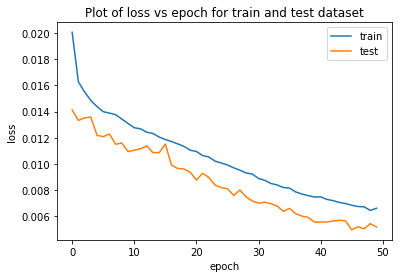

In [31]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## CNN

In [32]:
cnn_model = CNN(1,84,2).getModel() # n_steps = 1 , n_features = 84 , n_outputs = 2
cnn_model.compile(optimizer="adam",loss="mse")

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = cnn_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 4s 3ms/step - loss: 0.0178 - val_loss: 0.0136
Epoch 2/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.0144 - val_loss: 0.0127
Epoch 3/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 4/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 5/50
1096/1096 [==============================] - 3s 3ms/step - loss: 0.0125 - val_loss: 0.0114
Epoch 6/50
1096/1096 [==============================] - 3s 2ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 7/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 8/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 9/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 10/50
1096/1096 [==============================] - 2s 2ms/step - loss: 0.011

In [34]:
y_pred_train = cnn_model.predict(X_train)
y_pred_test  = cnn_model.predict(X_test) 

print("-" * 50)

print_metrics(cnn_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 0s 1ms/step
--------------------------------------------------
Train MAE  value   : 0.056 
Train MSE  value   : 0.008 
Train RMSE value   : 0.088 
Train R2   value   : 0.799 
---------------------------------------------
Test  MAE  value   : 0.058 
Test  MSE  value   : 0.008 
Test  RMSE value   : 0.091 
Test  R2   value   : 0.776 


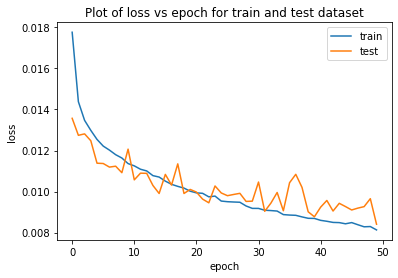

In [35]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## TCN

In [36]:
tcn_model = TCN_Model().getModel(1,84,2) # n_steps = 1 , n_features = 84 , n_outputs = 2
tcn_model.compile(optimizer="adam",loss="mse")

In [37]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = tcn_model.fit(X_train , 
                        y_train , 
                        epochs= 50 , 
                        verbose=1 ,
                        validation_split=0.3, 
                        validation_data=(X_val,y_val),
                        callbacks = callback)

Epoch 1/50
1096/1096 [==============================] - 19s 15ms/step - loss: 0.0205 - val_loss: 0.0160
Epoch 2/50
1096/1096 [==============================] - 16s 14ms/step - loss: 0.0182 - val_loss: 0.0151
Epoch 3/50
1096/1096 [==============================] - 15s 14ms/step - loss: 0.0179 - val_loss: 0.0152
Epoch 4/50
1096/1096 [==============================] - 15s 14ms/step - loss: 0.0174 - val_loss: 0.0153
Epoch 5/50
1096/1096 [==============================] - 16s 14ms/step - loss: 0.0172 - val_loss: 0.0151
Epoch 6/50
1096/1096 [==============================] - 15s 14ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 7/50
1096/1096 [==============================] - 15s 14ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 8/50
1096/1096 [==============================] - 16s 14ms/step - loss: 0.0166 - val_loss: 0.0149
Epoch 9/50
1096/1096 [==============================] - 15s 14ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 10/50
1096/1096 [==============================] - 16s 14m

In [38]:
y_pred_train = tcn_model.predict(X_train)
y_pred_test  = tcn_model.predict(X_test) 

print("-" * 50)

print_metrics(tcn_model , y_train , y_pred_train , y_test , y_pred_test)

137/137 [==============================] - 1s 6ms/step
--------------------------------------------------
Train MAE  value   : 0.077 
Train MSE  value   : 0.014 
Train RMSE value   : 0.118 
Train R2   value   : 0.633 
---------------------------------------------
Test  MAE  value   : 0.078 
Test  MSE  value   : 0.014 
Test  RMSE value   : 0.119 
Test  R2   value   : 0.618 


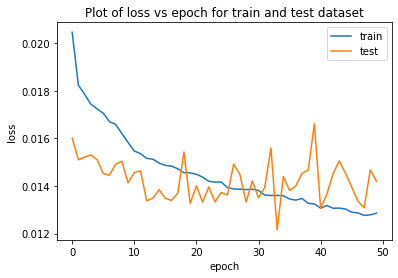

In [39]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()